.. _series_tutorial:

.. currentmodule:: thunder

# Series

A ``Series`` object is a distributed collection of 1d arrays, all of which share a common index. It supports several manipulations and computations on 1d data, some of which take the index into account.

The most common examples of Series objects are likely time series data, in which each array represents a quantity that has been temporally sampled at regular intervals. In imaging data, a single record within a Series might consist of a time series of measurements at a point within the imaging volume, as in the fish-series example data from the "basic usage" tutorial.

The keys associated with Series records can be any data used to identify the series; however for imaging data, the keys are commonly tuples of integers, representing the indicies of the position within the imaging volume from which the time series originates. For example, a Series record representing a time series from an outer corner of a 3-dimensional imaged volume might have a key of (0, 0, 0), with the value being an array representing the measurements at that point over the course of an experiment: [112, 110, 118, ..., 124].

Setup plotting
--------------

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

Loading series
--------------
Series can be loaded from a ``ThunderContext`` using the `loadSeries` method. (See the ``Input formats`` tutorial for more detail on loading methods and formats.) Here, we'll again load the "fish-series" example data set:

In [4]:
data = tsc.loadExample('fish-series')

Inspection
----------
Let's plot a random subset of the data using the ``subset`` method, which thresholds based on the standard deviation:

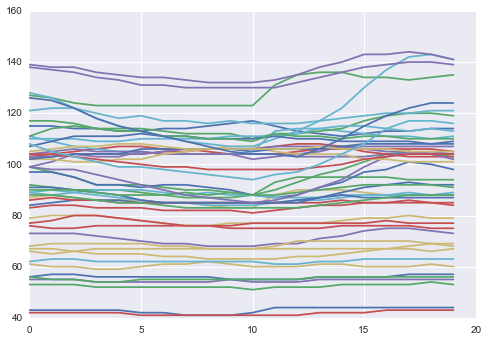

In [7]:
examples = data.subset(nsamples=50, thresh=1)
plt.plot(examples.T[0:20,:]);

Note the variation in raw intensity levels.

Preprocessing
-------------
A ``Series`` object has methods for normalizing and standardizing data, which can be useful during preprocessing. For example, ``center`` subtracts the mean, and ``normalize`` subtracts and divides by a baseline (either the mean, or a percentile). Note the changes in the y-axis.

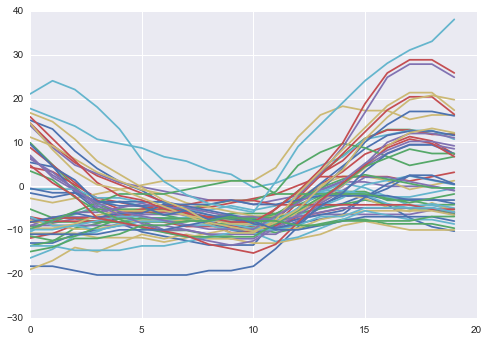

In [8]:
examples = data.center().subset(nsamples=50, thresh=10)
plt.plot(examples.T[0:20,:]);

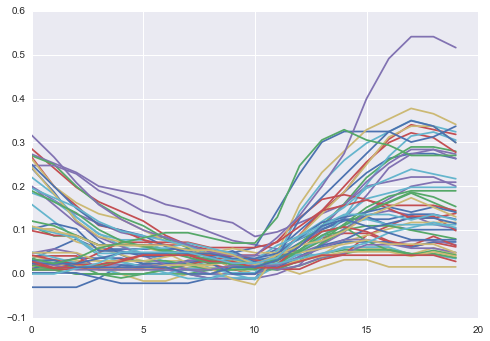

In [9]:
examples = data.toTimeSeries().normalize(baseline='percentile').subset(nsamples=50, thresh=0.1)
plt.plot(examples.T[0:20,:]);

Related methods include ``center``, ``standardize``, and ``detrend``.

Selections
----------
A ``Series`` has a 1d index, which can be used to subselect values.

In [10]:
data.index.shape

(240,)

For example, to select a range:

In [12]:
data.between(0,8).first()

((0, 0, 0), array([ 26.,  26.,  26.,  26.,  26.,  26.,  26.,  25.,  26.]))

Note that the index changes to reflect the subselected range:

In [13]:
data.between(0,8).index

[0, 1, 2, 3, 4, 5, 6, 7, 8]

We can also select based on an arbitrary criterion function:

In [14]:
data.select(lambda x: x < 5).index

[0, 1, 2, 3, 4]

The default index generated for ``Series`` objects will be the range of integers starting at zero and ending one before the length of the series data, as shown in these examples. However, other data types can also be used as the index for a series object, such as a sequence of strings, providing text labels for each element in the series array. See the ``Regression`` tutorial for an example of this usage.

Statistics
----------
A ``Series`` can be summarized with statistics both within and across records. To summarize across records:

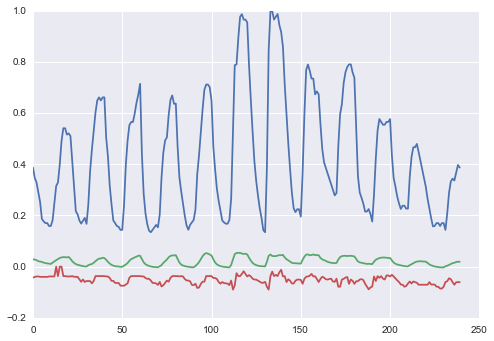

In [15]:
plt.plot(data.toTimeSeries().normalize().max());
plt.plot(data.toTimeSeries().normalize().mean());
plt.plot(data.toTimeSeries().normalize().min());

To summarize within records:

In [16]:
data.seriesMean().first()

((0, 0, 0), 25.824999999999999)

In [17]:
data.seriesStdev().first()

((0, 0, 0), 0.37996710383926657)

We can also correlate each record with a signal of interest. As expected, for a random signal, the correlation should be low.

In [18]:
from numpy import random
signal = random.randn(240)
data.correlate(signal).first()

((0, 0, 0), 0.039062227147807042)

Keys
----
We often use integer keys to index the records of a ``Series``. For instance, in the case where a ``Series`` represents imaging data, the integer keys may represent spatial position within the imaged volume.

A few convenience methods are provided for working with keys. First, the attribute ``dims`` contains information about the range of the keys. Computing this requires a pass through the data, but if computed on a ``Series`` it will be inherited by all derived objects, to avoid recomputation.

In [19]:
data.dims.max

(75, 86, 1)

In [20]:
data.dims.min

(0, 0, 0)

For keys that correspond to subscripts (e.g. indices of the rows and columns of a matrix, coordinates in space), we can convert between subscript and linear indexing. The default for these conversions is currently onebased subscript indexing, so we need to set ``onebased`` to ``False`` (this will likely change in a future release).

In [21]:
data.keys().take(10)

[(0, 0, 0),
 (1, 0, 0),
 (2, 0, 0),
 (3, 0, 0),
 (4, 0, 0),
 (5, 0, 0),
 (6, 0, 0),
 (7, 0, 0),
 (8, 0, 0),
 (9, 0, 0)]

In [22]:
data.subToInd(isOneBased=False).keys().take(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
data.subToInd(isOneBased=False).indToSub(isOneBased=False).keys().take(10)

[(0, 0, 0),
 (1, 0, 0),
 (2, 0, 0),
 (3, 0, 0),
 (4, 0, 0),
 (5, 0, 0),
 (6, 0, 0),
 (7, 0, 0),
 (8, 0, 0),
 (9, 0, 0)]

The ``query`` method can be used to average subselected records based on their (linearized) keys. It returns the mean value and  key for each of the provided index lists.

In [24]:
keys, values = data.query(inds=[[100,101],[200]], isOneBased=False)

In [25]:
keys

array([[ 25.5,   1. ,   0. ],
       [ 50. ,   2. ,   0. ]])

In [26]:
values.shape

(2, 240)

The ``pack`` method collects a series into a local array, reshaped based on the keys. If there are multiple values per record, all will be collected into the local array, so typically we select a subset of values before packing to avoid overwhelming the local processing node with data.

In [27]:
out = data.select(0).pack()
out.shape

(76, 87, 2)

In [28]:
out = data.between(0,2).pack()
out.shape

(3, 76, 87, 2)

Conversions
-----------
Subclasses of ``Series`` provide additional functionality for more specialized data types.

A ``TimeSeries`` provides methods like ``fourier``, for computing the statistics of a Fourier transform:

In [29]:
ts = data.toTimeSeries()
fr = ts.fourier(freq=5)
fr.index

['coherence', 'phase']

In [30]:
fr.select('coherence').first()

((0, 0, 0), 0.17186687287857189)

A ``RowMatrix`` provides a variety of methods for working with distributed matrices and matrix operations:

In [31]:
mat = data.toRowMatrix()

In [32]:
mat.cov().shape

(240, 240)